# Transformer (Ko-En) 번역기 Baseline
---
### 프로젝트 목표
한국어-영어 번역을 위한 트랜스포머 모델의 베이스라인에서 데이터 증강을 추가

**주요 변경 사항 (baseline 대비):**
1. **데이터 증강 (Back-translation)** 추가:
      - Meta AI의 NLLB-200 모델을 이용하여 한국어 문장을 영어로 번역한 뒤, 다시 한국어로 번역합니다.
      - 이렇게 얻은 역번역 문장은 원래 문장과는 표현이 다르지만 의미는 동일합니다.
      - 원본 한국어-영어 쌍 데이터에 이 역번역된 한국어 문장을 추가해, 모델이 더 다양한 표현을 학습하도록 합니다.
      - 데이터셋의 일부(1/10)를 증강하여, 학습 데이터의 크기를 약 1.1배로 확장했습니다.

## 1. 라이브러리 설치 및 임포트

In [1]:
!pip install sentencepiece
!pip install nltk

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
import os
from tqdm.notebook import tqdm
import math
import random

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## 2. 하이퍼파라미터 및 설정

- Transformer 논문(Attention is All You Need) 기본 구조와 유사한 설정
    - d_model=512, n_heads=8, n_layers=6 → 표준 Transformer base 모델 크기
    - d_ff=2048 → Position-wise FFN 내부 차원
    - max_len=50 → 문장 최대 길이 제한

In [3]:
# Model Hyperparameters
SRC_VOCAB_SIZE = 20000
TGT_VOCAB_SIZE = 20000
D_MODEL = 512
N_LAYERS = 6
N_HEADS = 8
D_FF = 2048
DROPOUT = 0.1
MAX_LEN = 50

# Training Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 3. 데이터 준비 및 전처리

In [4]:
!tar -xvf ~/work/0908/data/korean-english-park.dev.tar.gz

korean-english-park.dev.en
korean-english-park.dev.ko


In [5]:
!tar -xvf ~/work/0908/data/korean-english-park.test.tar.gz

korean-english-park.test.en
korean-english-park.test.ko


In [6]:
!tar -xvf ~/work/0908/data/korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


In [7]:
# 1. 데이터 경로 설정
data_dir = 'data'
train_kor_path = os.path.join(data_dir, 'korean-english-park.train.ko')
train_eng_path = os.path.join(data_dir, 'korean-english-park.train.en')
dev_kor_path = os.path.join(data_dir, 'korean-english-park.dev.ko')
dev_eng_path = os.path.join(data_dir, 'korean-english-park.dev.en')
test_kor_path = os.path.join(data_dir, 'korean-english-park.test.ko')
test_eng_path = os.path.join(data_dir, 'korean-english-park.test.en')

# 2. 원본 데이터 로딩
with open(train_kor_path, "r", encoding='utf-8') as f: train_kor_raw = f.read().splitlines()
with open(train_eng_path, "r", encoding='utf-8') as f: train_eng_raw = f.read().splitlines()
with open(dev_kor_path, "r", encoding='utf-8') as f: dev_kor_raw = f.read().splitlines()
with open(dev_eng_path, "r", encoding='utf-8') as f: dev_eng_raw = f.read().splitlines()
with open(test_kor_path, "r", encoding='utf-8') as f: test_kor_raw = f.read().splitlines()
with open(test_eng_path, "r", encoding='utf-8') as f: test_eng_raw = f.read().splitlines()

print(f"Train: {len(train_kor_raw)}, Dev: {len(dev_kor_raw)}, Test: {len(test_kor_raw)}")

Train: 94123, Dev: 1000, Test: 2000


In [8]:
import torch
from transformers import pipeline
import time

# (이전에 정의한 back_translate_nllb_optimized 함수를 그대로 사용)
def back_translate_nllb_optimized(sentences, chunk_size=1000, batch_size=32):
    """
    역번역을 진행하면서 진행 상황을 출력하고, 효율성을 높이는 함수.
    """
    augmented_sentences = []
    total_sentences = len(sentences)

    print(f"총 {total_sentences}개의 문장을 역번역합니다...")

    start_time = time.time()

    for i in range(0, total_sentences, chunk_size):
        chunk_start = i
        chunk_end = min(i + chunk_size, total_sentences)

        translated_to_en = [
            result['translation_text'] for result in translator(sentences[chunk_start:chunk_end],
                                                               src_lang='kor_Hang',
                                                               tgt_lang='eng_Latn',
                                                               batch_size=batch_size)
        ]

        back_translated_to_ko = [
            result['translation_text'] for result in translator(translated_to_en,
                                                               src_lang='eng_Latn',
                                                               tgt_lang='kor_Hang',
                                                               batch_size=batch_size)
        ]

        augmented_sentences.extend(back_translated_to_ko)

        elapsed_time = time.time() - start_time
        print(f"[{chunk_end}/{total_sentences}] 문장 처리 완료 | 경과 시간: {elapsed_time:.2f}초")

    return augmented_sentences

# NLLB 모델 로드
translator = pipeline(
    'translation',
    model='facebook/nllb-200-distilled-600M',
    device=0 if torch.cuda.is_available() else -1
)

# 데이터 증강을 적용할 데이터의 양을 결정
# 전체 학습 데이터의 1/10만 사용
num_to_augment = len(train_kor_raw) // 10

train_kor_subset = train_kor_raw[:num_to_augment]
train_eng_subset = train_eng_raw[:num_to_augment]

print(f"\n데이터셋의 1/10인 {num_to_augment}개 문장에 대해 역번역을 시작합니다...")
augmented_train_kor_raw = back_translate_nllb_optimized(train_kor_subset)
print("데이터 증강 완료")

# 원본 데이터와 증강된 데이터를 합치기
# 증강된 데이터는 원본 문장의 1/10에 해당하므로, 총 데이터 크기는 1.1배가 됨
combined_train_kor_raw = train_kor_raw + augmented_train_kor_raw
combined_train_eng_raw = train_eng_raw + train_eng_subset

print(f"최종 학습 데이터 크기: 한국어 {len(combined_train_kor_raw)}, 영어 {len(combined_train_eng_raw)}")

Device set to use cuda:0



데이터셋의 1/10인 9412개 문장에 대해 역번역을 시작합니다...
총 9412개의 문장을 역번역합니다...
[1000/9412] 문장 처리 완료 | 경과 시간: 324.20초
[2000/9412] 문장 처리 완료 | 경과 시간: 674.30초
[3000/9412] 문장 처리 완료 | 경과 시간: 1097.54초
[4000/9412] 문장 처리 완료 | 경과 시간: 1482.46초


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[5000/9412] 문장 처리 완료 | 경과 시간: 1975.60초
[6000/9412] 문장 처리 완료 | 경과 시간: 2388.92초
[7000/9412] 문장 처리 완료 | 경과 시간: 2822.30초


Your input_length: 200 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 200 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


[8000/9412] 문장 처리 완료 | 경과 시간: 3327.83초


Your input_length: 200 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


[9000/9412] 문장 처리 완료 | 경과 시간: 3758.07초
[9412/9412] 문장 처리 완료 | 경과 시간: 3895.34초
데이터 증강 완료
최종 학습 데이터 크기: 한국어 103535, 영어 103535


- 중복된 문장 쌍 제거
- 소문자화 + 구두점 분리 + 특수문자 제거(. ? ! , 만 남김)

In [9]:
import re

def preprocess_sentence(sentence):
    """구두점, 특수문자 등 불필요한 부분을 제거하고 소문자로 변환합니다."""
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[\" \"]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

def clean_and_preprocess_corpus(kor_raw, eng_raw):
    """문장 쌍의 중복을 제거하고 각 문장을 전처리합니다."""
    # 1. zip으로 문장 쌍 생성 후 set으로 중복 제거
    cleaned_pairs = list(set(zip(kor_raw, eng_raw)))

    # 2. 각 문장 전처리
    kor_corpus, eng_corpus = [], []
    for kor, eng in cleaned_pairs:
        kor_corpus.append(preprocess_sentence(kor))
        eng_corpus.append(preprocess_sentence(eng))

    return kor_corpus, eng_corpus

# 증강된 데이터를 포함한 최종 학습 데이터에 대해 정제 및 전처리 수행
train_kor_corpus, train_eng_corpus = clean_and_preprocess_corpus(combined_train_kor_raw, combined_train_eng_raw)
dev_kor_corpus, dev_eng_corpus = clean_and_preprocess_corpus(dev_kor_raw, dev_eng_raw)
test_kor_corpus, test_eng_corpus = clean_and_preprocess_corpus(test_kor_raw, test_eng_raw)

print(f"\n정제 및 전처리 후 최종 데이터 크기: Train: {len(train_kor_corpus)}, Dev: {len(dev_kor_corpus)}, Test: {len(test_kor_corpus)}")


정제 및 전처리 후 최종 데이터 크기: Train: 88369, Dev: 1000, Test: 1996


- SentencePiece 토크나이저 학습 + 불러오기

In [10]:
import sentencepiece as spm
import numpy as np

def generate_tokenizer(corpus, vocab_size, lang, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    file = f'./{lang}_corpus.txt'
    model_prefix = f'{lang}_spm'
    with open(file, 'w', encoding='utf-8') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    spm.SentencePieceTrainer.Train(
        f'--input={file} --model_prefix={model_prefix} --vocab_size={vocab_size}' + 
        f' --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{model_prefix}.model')
    return tokenizer

# 증강된 데이터로 SentencePiece 토크나이저 재학습
SRC_VOCAB_SIZE = 20000
TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(train_kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(train_eng_corpus, TGT_VOCAB_SIZE, "en")

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=./ko_corpus.txt --model_prefix=ko_spm --vocab_size=20000 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./ko_corpus.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
 

- 입력 파일 : ko_corpus.txt
- 결과 파일 prefix: ko_spm → ko_spm.model, ko_spm.vocab 생성
- vocab 크기 : 20,000
- 특수 토큰 ID : pad=0, bos=1, eos=2, unk=3
- 영어도 동일하게 en_corpus.txt → en_spm.model, en_spm.vocab 으로 학습
<br/>

- 모델 유형 : UNIGRAM → BPE 말고 유니그램 기반 서브워드 모델
- 문자 커버리지 : 99.95% 문자를 커버 → 드물게 쓰이는 문자는 버림
- 최대 문장 길이: 4192자
- 최대 서브워드 길이: 16자
- 스레드 수 : 병렬 학습을 위해 16개 스레드 사용
<br/>

- 학습에 사용된 문장 수 : 94,123개 (한/영 동일)
- ```<pad>, <s>, </s>, <unk>``` 토큰을 vocab에 고정 추가
<br/>

- 한국어
    - 전체 문자 개수 : 약 581만
    - 고유 문자 수 : 1,324종 (한글 + 특수기호 포함)
    - 커버율 : 99.95% → corpus 대부분의 문자가 반영됨
- 영어
    - 전체 문자 개수: 약 1,196만
    - 고유 문자 수: 82종 (영문 알파벳 + 기호)
<br/>

- EM (Expectation-Maximization) 반복을 통해 서브워드를 점점 줄여감
- size : 남은 서브워드 후보 개수
- obj : likelihood 값 (클수록 모델이 데이터를 잘 설명함)
- num_tokens : 전체 토큰화 결과 개수
- num_tokens/piece : 평균적으로 하나의 서브워드가 몇 번 등장했는지

## 5. 데이터셋 및 DataLoader 구축

- 번역 데이터셋을 PyTorch에서 학습 가능한 형태로 구성하는 과정
- 문장 쌍을 토큰화하여 텐서로 변환
- 배치마다 패딩 처리
- DataLoader로 학습용 배치 생성

In [17]:
# PyTorch Dataset 및 DataLoader 인스턴스 생성
from torch.utils.data import Dataset, DataLoader
import torch

# TranslationDataset 클래스 정의
class TranslationDataset(Dataset):
    def __init__(self, src_corpus, tgt_corpus, src_tokenizer, tgt_tokenizer):
        self.src_corpus = src_corpus
        self.tgt_corpus = tgt_corpus
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer

    def __len__(self):
        return len(self.src_corpus)

    def __getitem__(self, idx):
        src = self.src_tokenizer.encode_as_ids(self.src_corpus[idx])
        tgt = self.tgt_tokenizer.encode_as_ids(self.tgt_corpus[idx])

        # 텐서의 데이터 타입을 torch.long으로 명시적으로 지정
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

# collate_fn 함수
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        # 여기에 SOS/EOS 토큰을 추가하거나, 이미 토크나이저에서 처리했다면 그대로 사용
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_padded = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=ko_tokenizer.pad_id())
    tgt_padded = torch.nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=en_tokenizer.pad_id())
    return src_padded, tgt_padded

# 증강된 데이터셋으로 TranslationDataset 인스턴스 생성
train_dataset = TranslationDataset(train_kor_corpus, train_eng_corpus, ko_tokenizer, en_tokenizer)
valid_dataset = TranslationDataset(dev_kor_corpus, dev_eng_corpus, ko_tokenizer, en_tokenizer)
test_dataset = TranslationDataset(test_kor_corpus, test_eng_corpus, ko_tokenizer, en_tokenizer)

# DataLoader 인스턴스 생성 (변경 없음)
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in valid_loader: {len(valid_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 1381
Number of batches in valid_loader: 16
Number of batches in test_loader: 32


## 6. 트랜스포머 모델 정의

In [18]:
class PositionalEncoding(nn.Module):
    """
    입력 임베딩에 위치 정보를 추가하는 클래스입니다.
    Transformer 모델은 순서 정보가 없으므로, 토큰의 위치를 알려주기 위해 sin/cos 함수를 사용합니다.
    이 방식은 고정 위치 인코딩으로, 학습되지 않는 파라미터(buffer)로 등록됩니다.
    """
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # sin/cos 함수에 사용할 div_term 계산: 주파수 조절을 위한 값
        div_term = torch.exp(torch.arange(0, emb_size, 2) * (-math.log(10000.0) / emb_size))
        # 각 위치(0~maxlen)에 대한 인덱스 생성
        position = torch.arange(maxlen).unsqueeze(1)
        # 위치 임베딩 행렬 초기화 (maxlen, emb_size)
        pos_embedding = torch.zeros(maxlen, emb_size)
        # 짝수 인덱스: sin 함수 적용
        pos_embedding[:, 0::2] = torch.sin(position * div_term)
        # 홀수 인덱스: cos 함수 적용
        pos_embedding[:, 1::2] = torch.cos(position * div_term)
        # 배치 차원 추가 (1, maxlen, emb_size)
        pos_embedding = pos_embedding.unsqueeze(0)
        self.dropout = nn.Dropout(dropout)
        # 학습되지 않는 파라미터로 등록
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        """
        Args:
            token_embedding: (batch_size, seq_len, emb_size)
        Returns:
            token_embedding + pos_embedding: 위치 정보가 더해진 임베딩
        """
        return self.dropout(token_embedding + self.pos_embedding[:, :token_embedding.size(1), :])

class MultiHeadAttention(nn.Module):
    """
    다중 헤드 어텐션 메커니즘을 구현한 클래스.
    쿼리, 키, 값 행렬을 여러 헤드로 분할하여 병렬로 어텐션을 계산하고, 결과를 결합합니다.
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads  # 각 헤드의 차원
        # 쿼리, 키, 값 행렬을 위한 선형 변환 레이어
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        # 최종 출력 선형 변환 레이어
        self.linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        스케일드 닷-프로덕트 어텐션 계산.
        Args:
            Q: 쿼리 행렬
            K: 키 행렬
            V: 값 행렬
            mask: 어텐션 마스크 (선택적)
        Returns:
            out: 어텐션 가중치 적용된 값 행렬
            attentions: 어텐션 가중치 행렬
        """
        d_k = Q.size(-1)
        QK = torch.matmul(Q, K.transpose(-1, -2))  # QK^T 계산
        scaled_qk = QK / math.sqrt(d_k)  # 스케일링
        if mask is not None:
            scaled_qk += (mask * -1e9)  # 마스크 적용 (매우 작은 값 더하기)
        attentions = nn.Softmax(dim=-1)(scaled_qk)  # 소프트맥스 적용
        out = torch.matmul(attentions, V)  # 가중치 적용
        return out, attentions

    def split_heads(self, x):
        """
        입력 텐서를 여러 헤드로 분할.
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x: (batch_size, num_heads, seq_len, depth)
        """
        bsz, seq_len, _ = x.size()
        x = x.view(bsz, seq_len, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)  # 차원 재배치

    def combine_heads(self, x):
        """
        분할된 헤드를 다시 결합.
        Args:
            x: (batch_size, num_heads, seq_len, depth)
        Returns:
            x: (batch_size, seq_len, d_model)
        """
        bsz, _, seq_len, _ = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()
        return x.view(bsz, seq_len, self.d_model)

    def forward(self, Q, K, V, mask=None):
        """
        Args:
            Q: 쿼리 입력 (batch_size, seq_len, d_model)
            K: 키 입력
            V: 값 입력
            mask: 어텐션 마스크
        Returns:
            out: 어텐션 적용된 출력
            attention_weights: 어텐션 가중치
        """
        # 헤드 분할 후 어텐션 계산
        WQ = self.split_heads(self.W_q(Q))
        WK = self.split_heads(self.W_k(K))
        WV = self.split_heads(self.W_v(V))
        out, attention_weights = self.scaled_dot_product_attention(WQ, WK, WV, mask)
        # 헤드 결합 후 선형 변환
        out = self.combine_heads(out)
        out = self.linear(out)
        return out, attention_weights

class PoswiseFeedForwardNet(nn.Module):
    """
    포지션 와이즈 피드포워드 네트워크.
    각 위치별로 독립적으로 적용되는 2층 완전 연결 네트워크 (ReLU 활성화 함수 사용).
    """
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)  # 첫 번째 레이어 (차원 확장)
        self.fc2 = nn.Linear(d_ff, d_model)  # 두 번째 레이어 (원래 차원으로 복원)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x: (batch_size, seq_len, d_model)
        """
        return self.fc2(self.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    """
    인코더의 단일 레이어.
    셀프 어텐션과 피드포워드 네트워크를 포함하며, 레이어 정규화와 드롭아웃을 적용합니다.
    """
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)  # 첫 번째 정규화
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)  # 두 번째 정규화
        self.do = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        Args:
            x: 입력 텐서
            mask: 패딩 마스크
        Returns:
            out: 출력 텐서
            enc_attn: 셀프 어텐션 가중치
        """
        residual = x
        # 셀프 어텐션 + 드롭아웃 + 잔차 연결
        out, enc_attn = self.enc_self_attn(self.norm_1(x), self.norm_1(x), self.norm_1(x), mask)
        out = self.do(out) + residual
        residual = out
        # 피드포워드 네트워크 + 드롭아웃 + 잔차 연결
        out = self.ffn(self.norm_2(out))
        out = self.do(out) + residual
        return out, enc_attn

class DecoderLayer(nn.Module):
    """
    디코더의 단일 레이어.
    셀프 어텐션, 인코더-디코더 어텐션, 피드포워드 네트워크를 포함합니다.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)  # 셀프 어텐션
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)  # 인코더-디코더 어텐션
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_3 = nn.LayerNorm(d_model, eps=1e-6)
        self.do = nn.Dropout(dropout)

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Args:
            x: 디코더 입력
            enc_out: 인코더 출력
            dec_enc_mask: 디코더-인코더 어텐션 마스크
            padding_mask: 패딩 마스크
        Returns:
            out: 출력 텐서
            dec_attn: 셀프 어텐션 가중치
            dec_enc_attn: 인코더-디코더 어텐션 가중치
        """
        residual = x
        # 셀프 어텐션 (look-ahead 마스크 적용)
        out, dec_attn = self.dec_self_attn(self.norm_1(x), self.norm_1(x), self.norm_1(x), mask=padding_mask)
        out = self.do(out) + residual
        residual = out
        # 인코더-디코더 어텐션
        out, dec_enc_attn = self.enc_dec_attn(self.norm_2(out), enc_out, enc_out, mask=dec_enc_mask)
        out = self.do(out) + residual
        residual = out
        # 피드포워드 네트워크
        out = self.ffn(self.norm_3(out))
        out = self.do(out) + residual
        return out, dec_attn, dec_enc_attn

class Encoder(nn.Module):
    """
    인코더 전체 구조.
    임베딩 레이어, 위치 인코딩, 여러 개의 인코더 레이어로 구성됩니다.
    """
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout, vocab_size):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)  # 토큰 임베딩
        self.pos_encoding = PositionalEncoding(d_model, dropout)  # 위치 인코딩
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    def forward(self, x, mask):
        """
        Args:
            x: 입력 시퀀스 (batch_size, seq_len)
            mask: 패딩 마스크
        Returns:
            out: 인코더 출력
            enc_attns: 각 레이어의 어텐션 가중치 리스트
        """
        out = self.embedding(x) * math.sqrt(self.d_model)  # 임베딩 스케일링
        out = self.pos_encoding(out)  # 위치 인코딩 추가
        enc_attns = []
        for layer in self.enc_layers:
            out, enc_attn = layer(out, mask)
            enc_attns.append(enc_attn)
        return out, enc_attns

class Decoder(nn.Module):
    """
    디코더 전체 구조.
    임베딩 레이어, 위치 인코딩, 여러 개의 디코더 레이어로 구성됩니다.
    """
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout, vocab_size):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.dec_layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        """
        Args:
            x: 디코더 입력 시퀀스
            enc_out: 인코더 출력
            dec_enc_mask: 디코더-인코더 어텐션 마스크
            padding_mask: 패딩 마스크
        Returns:
            out: 디코더 출력
            dec_attns: 셀프 어텐션 가중치 리스트
            dec_enc_attns: 인코더-디코더 어텐션 가중치 리스트
        """
        out = self.embedding(x) * math.sqrt(self.d_model)
        out = self.pos_encoding(out)
        dec_attns, dec_enc_attns = [], []
        for layer in self.dec_layers:
            out, dec_attn, dec_enc_attn = layer(out, enc_out, dec_enc_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        return out, dec_attns, dec_enc_attns

class Transformer(nn.Module):
    """
    전체 Transformer 모델.
    인코더와 디코더를 연결하고, 최종 출력 레이어를 포함합니다.
    """
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, dropout):
        super(Transformer, self).__init__()
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout, src_vocab_size)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout, tgt_vocab_size)
        self.fc = nn.Linear(d_model, tgt_vocab_size)  # 최종 출력 레이어

    def forward(self, src, tgt):
        """
        Args:
            src: 소스 시퀀스 (batch_size, src_seq_len)
            tgt: 타겟 시퀀스 (batch_size, tgt_seq_len)
        Returns:
            logits: 최종 예측 로짓 (batch_size, tgt_seq_len, tgt_vocab_size)
            enc_attns: 인코더 어텐션 가중치 리스트
            dec_attns: 디코더 셀프 어텐션 가중치 리스트
            dec_enc_attns: 디코더-인코더 어텐션 가중치 리스트
        """
        # 마스크 생성
        src_mask = (src == ko_tokenizer.pad_id()).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt == en_tokenizer.pad_id()).unsqueeze(1).unsqueeze(2)
        lookahead_mask = torch.triu(torch.ones(tgt.shape[1], tgt.shape[1]), diagonal=1).bool().to(device)
        tgt_mask = tgt_mask | lookahead_mask
        # 인코더/디코더 순전파
        enc_out, enc_attns = self.encoder(src, src_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns


## 7. 학습 설정

- ```nn.CrossEntropyLoss``` : 다중 분류(classification)에서 가장 많이 쓰는 손실 함수
- <pad> 토큰은 학습에 불필요하므로 손실 계산에서 제외
    - 예를 들어 패딩된 부분이 많아도 loss가 그 부분 때문에 왜곡되지 않음
<br/>

- 옵티마이저 : Adam
- lr=0.0001 : 학습률(learning rate)
- betas=(0.9, 0.98) : 모멘텀 계수 (논문에서 제안된 설정)
- 0.9 : 1차 모멘텀(gradient 평균)
- 0.98 : 2차 모멘텀(gradient 제곱 평균)
- eps=1e-9 : 아주 작은 값 → 분모가 0 되는 걸 방지
- 이 설정은 논문 “Attention is All You Need”의 Transformer 원 논문에 나온 Adam 설정과 거의 동일

In [19]:
model = Transformer(N_LAYERS, D_MODEL, N_HEADS, D_FF, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=ko_tokenizer.pad_id())
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## 8. 학습 및 검증

In [20]:
import time

def train(model, iterator, optimizer, criterion, clip, log_interval=100):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch[0].to(device)
        tgt = batch[1].to(device)

        optimizer.zero_grad()

        output, _, _, _ = model(src, tgt[:,:-1])

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        # log_interval 마다 로그 출력
        if (i + 1) % log_interval == 0:
            print(f"  - Step {i+1}/{len(iterator)} | Batch Loss: {loss.item():.4f}")

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch[0].to(device)
            tgt = batch[1].to(device)

            output, _, _, _ = model(src, tgt[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:,1:].contiguous().view(-1)

            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# --- 학습 루프 ---
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    print(f"Epoch {epoch+1:02} / {EPOCHS:02}")
    print("Training...")
    train_loss = train(model, train_loader, optimizer, criterion, 1)

    print("Evaluating...")
    valid_loss = evaluate(model, valid_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-baseline.pt')
        print("best model saved.")

    print(f'Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print("-" * 30)

Epoch 01 / 10
Training...
  - Step 100/1381 | Batch Loss: 42.0608
  - Step 200/1381 | Batch Loss: 30.7177
  - Step 300/1381 | Batch Loss: 24.4163
  - Step 400/1381 | Batch Loss: 20.6334
  - Step 500/1381 | Batch Loss: 18.7744
  - Step 600/1381 | Batch Loss: 16.8376
  - Step 700/1381 | Batch Loss: 15.6078
  - Step 800/1381 | Batch Loss: 14.5177
  - Step 900/1381 | Batch Loss: 13.6408
  - Step 1000/1381 | Batch Loss: 12.2240
  - Step 1100/1381 | Batch Loss: 12.3261
  - Step 1200/1381 | Batch Loss: 11.4049
  - Step 1300/1381 | Batch Loss: 10.7402
Evaluating...
best model saved.
Time: 10m 32s
	Train Loss: 19.841 | Train PPL: 413741704.334
	 Val. Loss: 8.998 |  Val. PPL: 8084.761
------------------------------
Epoch 02 / 10
Training...
  - Step 100/1381 | Batch Loss: 9.5238
  - Step 200/1381 | Batch Loss: 9.7650
  - Step 300/1381 | Batch Loss: 8.9473
  - Step 400/1381 | Batch Loss: 8.8380
  - Step 500/1381 | Batch Loss: 8.7344
  - Step 600/1381 | Batch Loss: 7.8921
  - Step 700/1381 | Batch

## 9. 번역 및 성능 평가 (BLEU)

In [21]:
def translate_sentence(sentence, src_tokenizer, tgt_tokenizer, model, device, max_len=50):
    model.eval()
    src_tokens = src_tokenizer.encode_as_ids(sentence)
    src_tensor = torch.LongTensor(src_tokens).unsqueeze(0).to(device)
    tgt_tokens = [tgt_tokenizer.bos_id()]
    for i in range(max_len):
        tgt_tensor = torch.LongTensor(tgt_tokens).unsqueeze(0).to(device)
        with torch.no_grad():
            output, _, _, dec_enc_attns = model(src_tensor, tgt_tensor)
        pred_token = output.argmax(2)[:,-1].item()
        tgt_tokens.append(pred_token)
        if pred_token == tgt_tokenizer.eos_id():
            break
    tgt_sentence = tgt_tokenizer.decode_ids(tgt_tokens)
    return tgt_sentence, dec_enc_attns

example_idx = 0
src = test_kor_raw[example_idx]
trg = test_eng_raw[example_idx]
translation, attention = translate_sentence(src, ko_tokenizer, en_tokenizer, model, device)
print(f'src = {src}')
print(f'trg = {trg}')
print(f'predicted trg = {translation}')

src = 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
trg = Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.
predicted trg = s are concerned to protect their concerns and the country such concerns and the concerns to the concern about the problem . the law and the law enforcement of the law enforcement of the law enforcement and the law enforcement and


## 10. 어텐션 시각화

In [ ]:
pwd

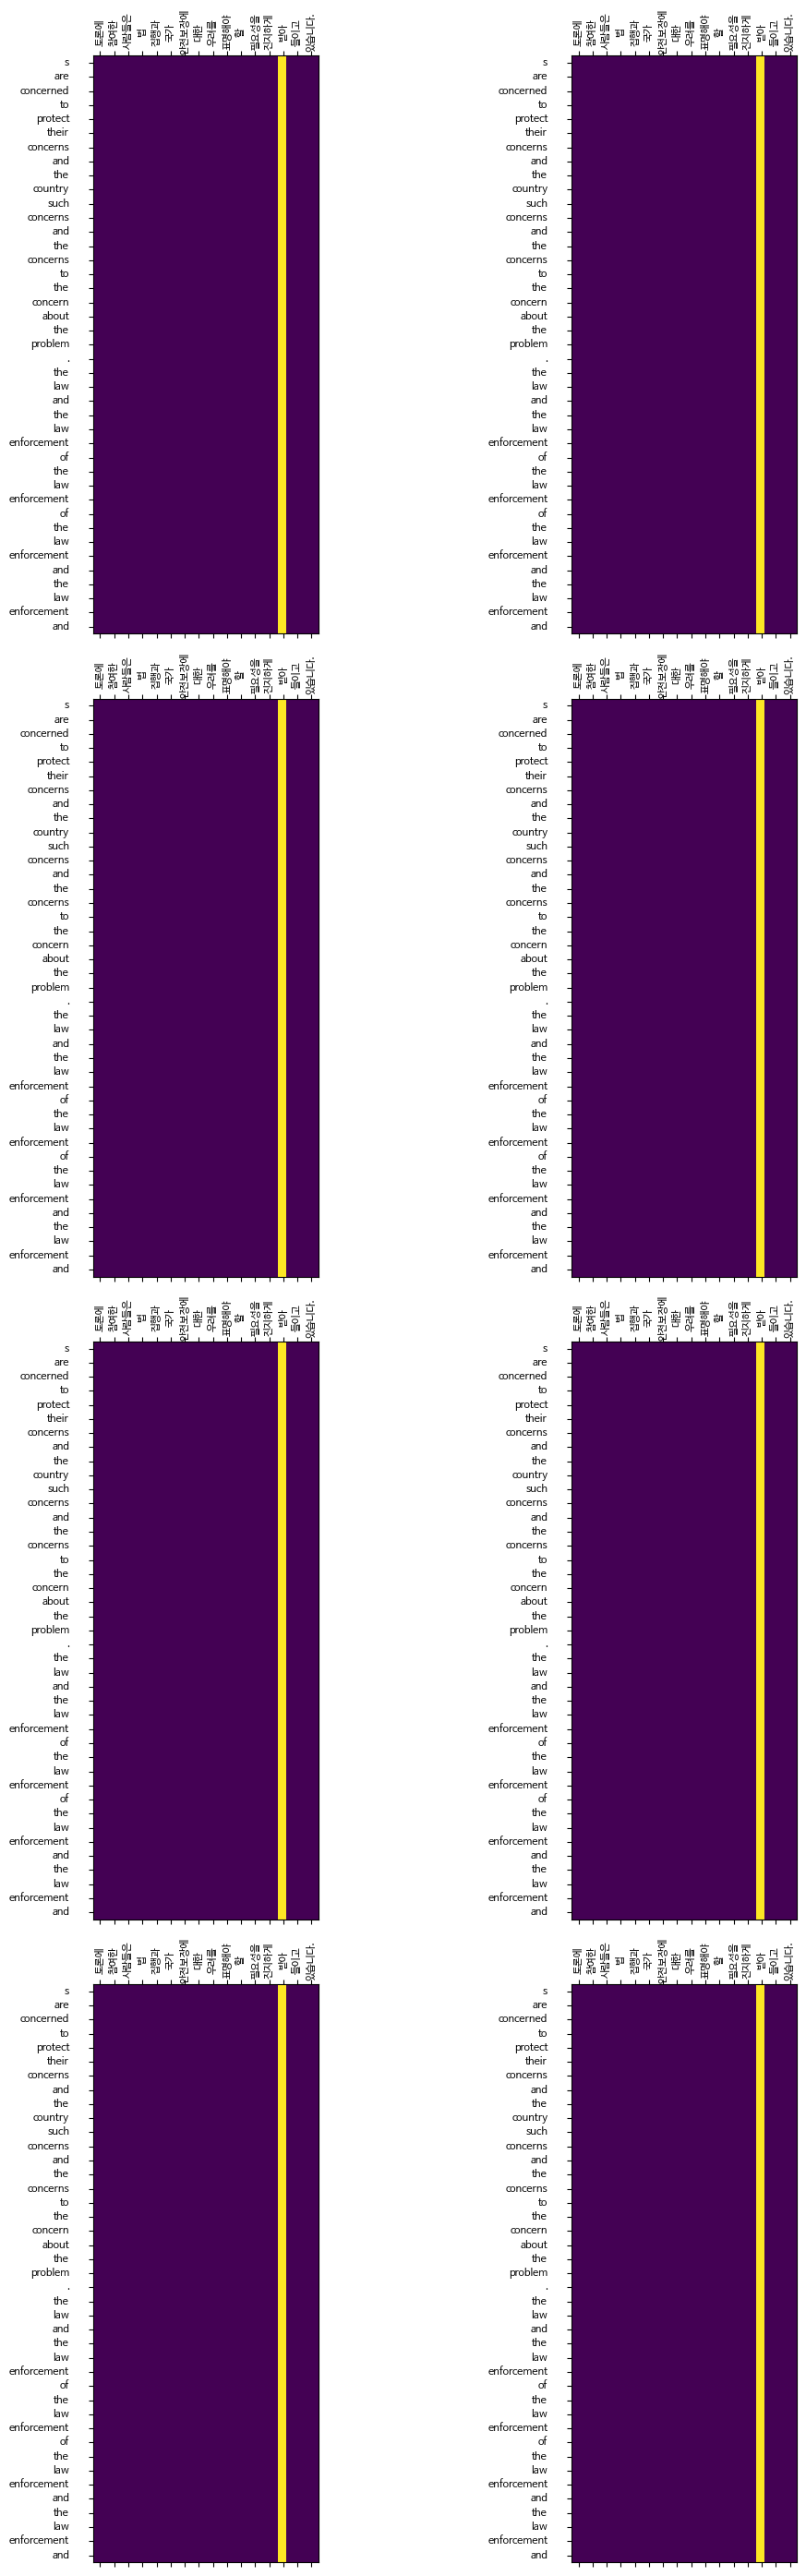

In [22]:
def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
    """어텐션 맵을 시각화합니다."""
    assert n_rows * n_cols == n_heads

    font_path = 'NanumBarunGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=8)

    fig = plt.figure(figsize=(12, 28))  # x축을 조금 넓혀서 압축 줄임 (10->12)

    # 번역된 문장과 원본 문장을 토큰 단위로 분리
    sentence_tokens = sentence.split()
    translation_tokens = translation.split()

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # attention shape: (head_idx, tgt_len, src_len)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        # extent 명시: (-0.5, src_len-0.5, tgt_len-0.5, -0.5)로 ticks와 맞춤
        src_len = len(sentence_tokens)
        tgt_len = len(translation_tokens)
        cax = ax.matshow(_attention, cmap='viridis', extent=[-0.5, src_len - 0.5, tgt_len - 0.5, -0.5])

        # 눈금 위치 설정
        ax.set_xticks(range(src_len))
        ax.set_yticks(range(tgt_len))

        # 라벨 설정: ha/va로 중앙 정렬
        ax.set_xticklabels(sentence_tokens, rotation=90, fontproperties=font_prop, ha='center', va='center')
        ax.set_yticklabels(translation_tokens, fontproperties=font_prop, ha='right', va='center')

        ax.tick_params(labelsize=8, pad=15)  # pad로 텍스트와 tick 간격 미세 조정

    plt.tight_layout()  # subplot 간 여백 자동 조정 (밀림 방지)
    plt.show()

display_attention(src, translation, attention[-1])

/tmp/ipykernel_259/1724441581.py:40: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


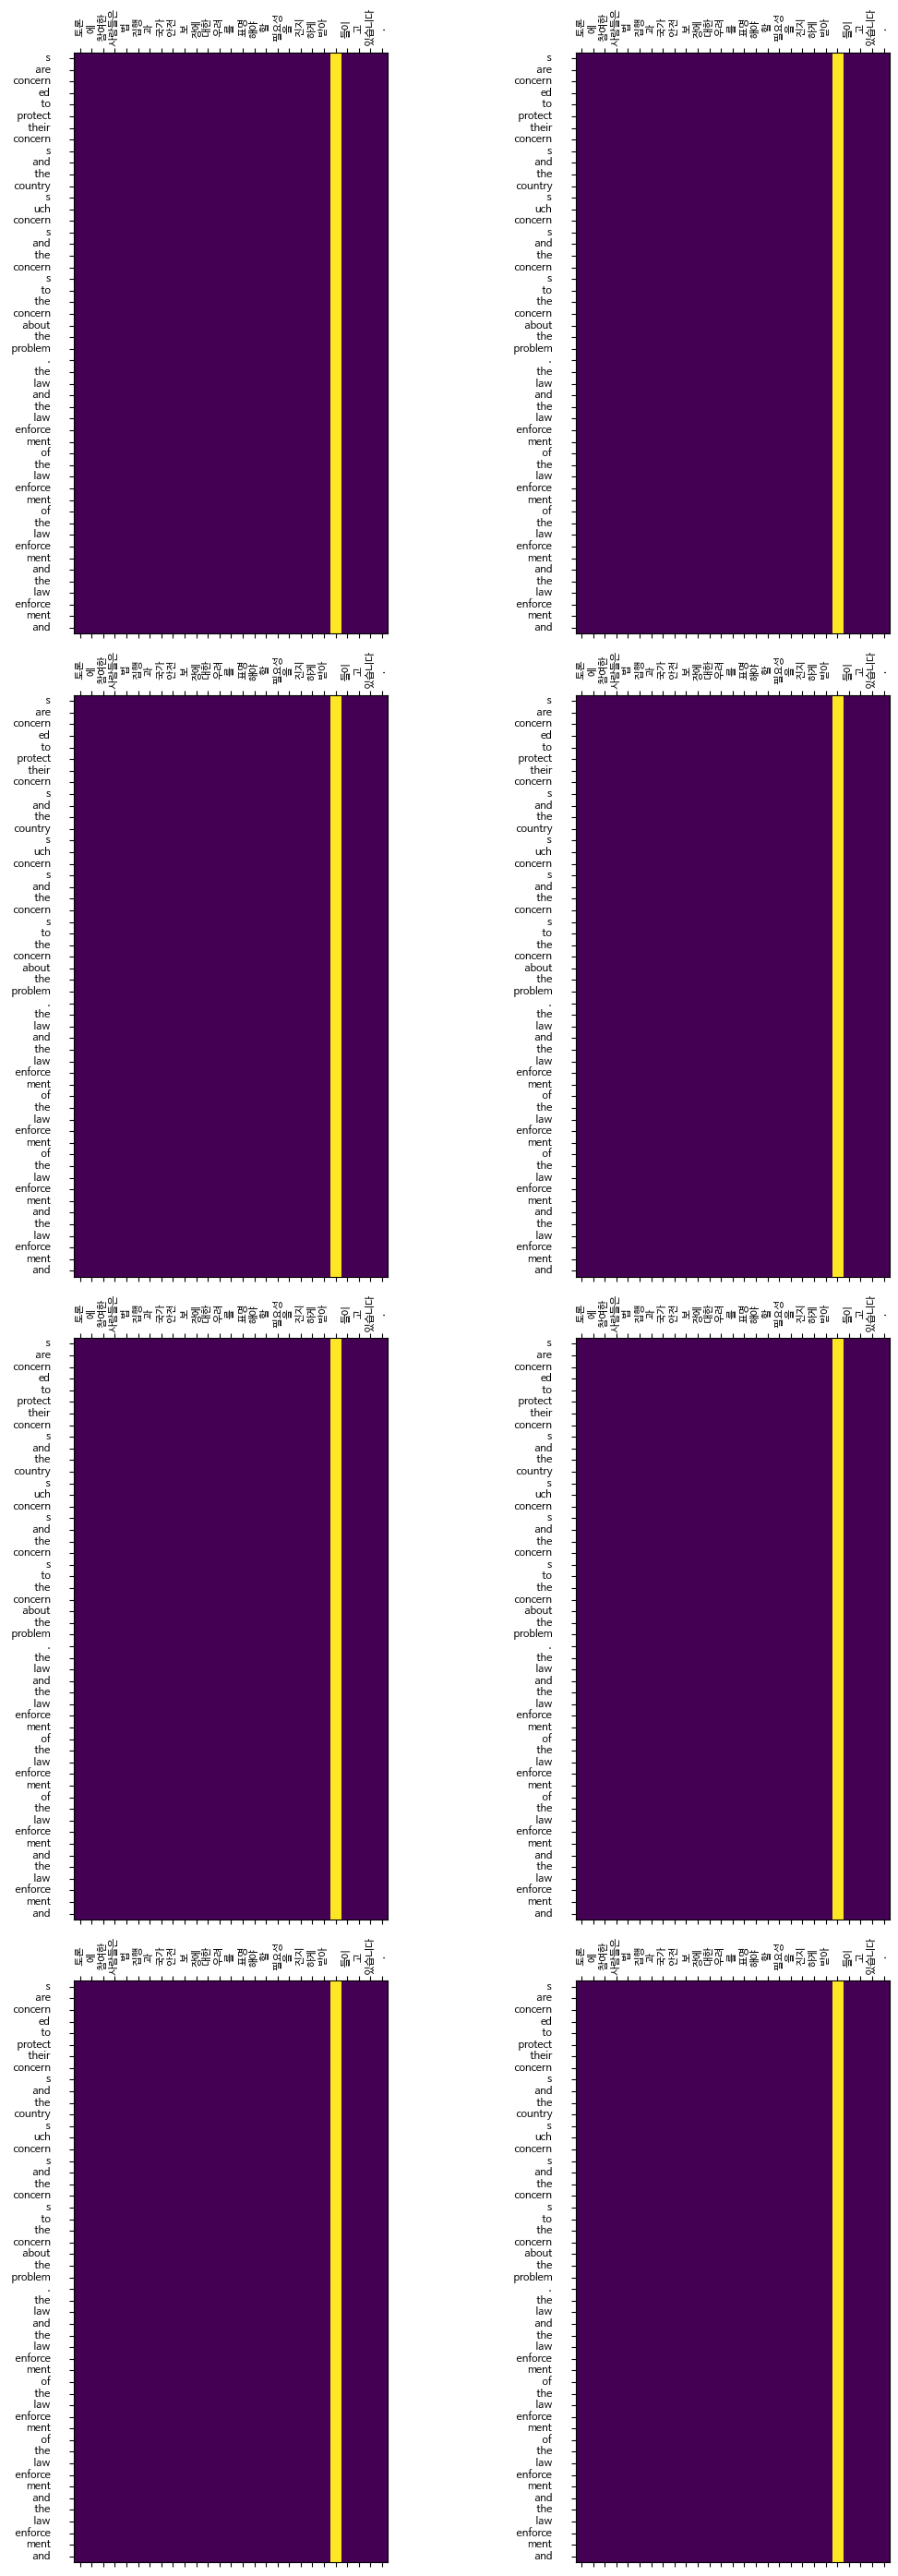

In [23]:
def display_attention_sp(src_sentence, tgt_sentence, attention, 
                         src_tokenizer, tgt_tokenizer,
                         n_heads=8, n_rows=4, n_cols=2):
    """SentencePiece 토큰 기준 어텐션 맵 시각화"""
    assert n_rows * n_cols == n_heads

    font_path = 'NanumBarunGothic.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=8)

    fig = plt.figure(figsize=(12, 28))

    # 1️SentencePiece 토큰화 (ID → piece)
    src_ids = src_tokenizer.encode_as_ids(src_sentence)
    tgt_ids = tgt_tokenizer.encode_as_ids(tgt_sentence)

    src_tokens = [src_tokenizer.id_to_piece(idx) for idx in src_ids]
    tgt_tokens = [tgt_tokenizer.id_to_piece(idx) for idx in tgt_ids]

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # attention shape: (n_heads, tgt_len, src_len)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        src_len = len(src_tokens)
        tgt_len = len(tgt_tokens)

        cax = ax.matshow(_attention, cmap='viridis',
                         extent=[-0.5, src_len - 0.5, tgt_len - 0.5, -0.5])

        # SentencePiece 토큰을 tick label로 붙임
        ax.set_xticks(range(src_len))
        ax.set_yticks(range(tgt_len))

        ax.set_xticklabels(src_tokens, rotation=90, fontproperties=font_prop, ha='center', va='center')
        ax.set_yticklabels(tgt_tokens, fontproperties=font_prop, ha='right', va='center')

        ax.tick_params(labelsize=8, pad=15)

    plt.tight_layout()
    plt.show()

display_attention_sp(
    src_sentence=src,              # 한국어 원문 문자열
    tgt_sentence=translation,      # 영어 번역 문자열
    attention=attention[-1],       # 마지막 layer attention
    src_tokenizer=ko_tokenizer, 
    tgt_tokenizer=en_tokenizer
)